<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C8/C8.html"><img src="../data/C8_nav.png" width="100"  style="float:right;" alt="C8"></a>
<h1>Salience Representation</h1> 
</div>

<br/>

<p>
Following Section 8.2.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we introduce in this notebook an enhanced log-frequency spectrogram referred to as <strong>salience representation</strong>. Exploiting the <a href="../C8/C8S2_InstantFreqEstimation.html">instantaneous frequency</a>, we show how the log-frequency spectrogram can be improved and refined, in particular in the low-frequency part of the spectrum. The salience representation as introduced in this notebook is inspired by the work of Salamon and Gómez.
</p> 
    
<ul>
<li><span style="color:black">
Justin Salamon and Emilia Gómez: <strong>Melody Extraction from Polyphonic Music Signals using Pitch Contour Characteristics.</strong> IEEE Transactions on Audio, Speech, and Language Processing, 20 (2012), pp. 1759&ndash;1770.
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_SalamonG12_MelodyExtraction_TASLP.txt"> Bibtex </a>
</span></li>
</ul>

## Running Example: Freischütz

As our running example throughout this notebook, we use a short excerpt of an aria from the opera "Der Freischütz" by Carl Maria von Weber. The main melody of this excerpt is performed by a soprano singer.

<img src="../data/C8/FMP_C8_F10a.png" width="300px" align="left" alt="FMP_C8_F10a">

<br clear="all" />

<audio style="width: 300px;" src="./music/candyshop_acapella.mp3" type="audio/mpeg" controls="controls"></audio>

The following figure shows a [logarithmically compressed](../C3/C3S1_LogCompression.html) spectrogram of the audio excerpt as well as a zoomed-in time&ndash;frequency section. In view of the [instantaneous frequency](../C8/C8S2_SalienceRepresentation.html) to be used, we chose a relatively small hop size parameter $H$.

/home/ssl/miniconda3/envs/FMP/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


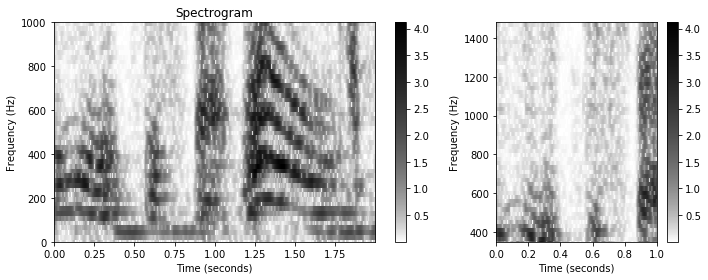

In [1]:
import numpy as np
import os, sys, librosa
from scipy import signal
from scipy import ndimage
from matplotlib import pyplot as plt
import IPython.display as ipd
from numba import jit

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c3
import libfmp.c6
import libfmp.c8

%matplotlib inline

# Load wav
fn_wav = os.path.join('.', 'music', 'candyshop_acapella.mp3')
Fs = 22050
x_full, Fs = librosa.load(fn_wav, sr=Fs)
x = x_full[17*Fs:19*Fs]

# Computation of STFT
N = 1024
H = 128
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, pad_mode='constant')
gamma = 1
Y = np.log(1 + gamma * np.abs(X))

figsize = (10,4)
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=figsize)        

ylim_zoom_pitch = [65, 90] 
ylim_zoom = [libfmp.c3.f_pitch(ylim_zoom_pitch[0]), libfmp.c3.f_pitch(ylim_zoom_pitch[1])]
xlim_zoom = [0,1]
cmap = libfmp.b.compressed_gray_cmap(alpha=5)

libfmp.b.plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, ax=[ax[0]], title='Spectrogram', 
                     colorbar=True, cmap=cmap);
ax[0].set_ylim([0, 1000])
libfmp.b.plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, ax=[ax[1]], title='', 
                     colorbar=True, cmap=cmap);
ax[1].set_ylim(ylim_zoom)
ax[1].set_xlim(xlim_zoom)

plt.tight_layout()

## Log-Frequency Spectrogram 

As preparation, let us recall the [log-frequency spectrogram](../C3/C3S1_SpecLogFreq-Chromagram.html) (Section 3.1.1 of <a href="http://www.music-processing.de">[Müller, FMP, Springer 2015]</a>. Let $x$ denote an audio signal sampled at a rate of $F_\mathrm{s}$ and $\mathcal{X}$ its STFT using a window length $N\in\mathbb{N}$ and hop size $H\in\mathbb{N}$. The frequency index $k\in[0:N/2]$ corresponds to

\begin{equation}
         F_\mathrm{coef}(k) := \frac{k\cdot F_\mathrm{s}}{N} 
\end{equation}

given Hertz. To obtain a [log-frequency spectrogram](../C3/C3S1_SpecLogFreq-Chromagram.html), one strategy is to pool or bin the STFT coefficients regarding the sets 

\begin{equation}
    P(p) := \{k:F_\mathrm{MIDI}(p-0.5) \leq   F_\mathrm{coef}(k) <  F_\mathrm{MIDI}(p+0.5)\}
\end{equation}

for pitch parameters $p\in[0:127]$. The [center frequencies](../C1/C1S3_FrequencyPitch.html) are given by

\begin{equation}
F_\mathrm{MIDI}(p) = 2^{(p-69)/12} \cdot 440.
\end{equation}

Instead of fixing a pitch and looking for all frequencies that lie in the resulting pitch band, one can also define a mapping $\mathrm{Bin}:\mathbb{R}\to\mathbb{Z}$ that assigns a pitch index to a given frequency:

\begin{equation}
    \mathrm{Bin}(\omega) := \left\lfloor 12\cdot\log_2\left(\frac{\omega}{440}\right)+69.5\right\rfloor.    
\end{equation}

Using this function, the binning can be expressed by

\begin{equation}
    P(p) := \{k: \mathrm{Bin}(F_\mathrm{coef}(k))=p\}.
\end{equation}

From this, we obtain a log-frequency spectrogram $\mathcal{Y}_\mathrm{LF}:\mathbb{Z}\times [0:127]$ via pooling: 

\begin{equation}
      \mathcal{Y}_\mathrm{LF}(n,p) := \sum_{k \in P(p)}{|\mathcal{X}(n,k)|^2}.
\end{equation}

The next code cell computes a log-frequency spectrogram of our Freischütz example using the implementation provided by the [FMP notebook on the log-frequency spectrogram and chromagram](../C3/C3S1_SpecLogFreq-Chromagram.html). 

<!--<img src="../data/C8/FMP_C8_F14a-b.png" width="500px" align="middle" alt="FMP_C8_F14a-b">-->

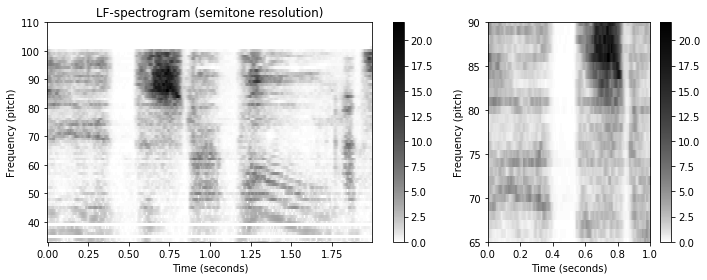

In [2]:
Y_LF, F_coef_hertz, F_coef_cents = libfmp.c8.compute_y_lf_bin(Y, Fs, N, R=100, 
                                                              F_min=32.703, F_max=11025)  

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=figsize)         

libfmp.b.plot_matrix(Y_LF, Fs=Fs/H, Fs_F=1, ax=[ax[0]], ylabel='Frequency (pitch)',
                     title='LF-spectrogram (semitone resolution)', 
                     colorbar=True, cmap=cmap);
ax[0].set_ylim([33, 110])
libfmp.b.plot_matrix(Y_LF, Fs=Fs/H, Fs_F=1, ax=[ax[1]], ylabel='Frequency (pitch)',
                     title='', colorbar=True, cmap=cmap);
ax[1].set_ylim(ylim_zoom_pitch)
ax[1].set_xlim(xlim_zoom)
plt.tight_layout()

## Refined Binning

We now extend the definition of the log-frequency spectrogram by considering a more general bin assignment. To this end, let $\omega_\mathrm{ref}\in\mathbb{R}$ be a reference frequency which is to be assigned to the bin index $1$. Furthermore, let $R\in\mathbb{R}$ (given in cents) be the desired resolution of the logarithmically spaced frequency axis. Then, for a frequency $\omega\in\mathbb{R}$ (given in Hertz), the bin index $\mathrm{Bin}(\omega)$ is defined as

\begin{equation}
    \label{eq:AudioDeco:Mel:SalSpec:binAssign}
    \mathrm{Bin}(\omega) := \left\lfloor \frac{1200}{R} \cdot\log_2\left(\frac{\omega}{\omega_\mathrm{ref}}\right)+1.5\right\rfloor.
\end{equation}

For example, $R=100$ yields a subdivision of the frequency axis with a resolution of $100$ cents (one semitone) per bin. Using $R=10$ results in a finer subdivision of the frequency axis, where each bin corresponds to $10$ cents (a tenth of a semitone). Based on the bin mapping function,  we now extend the definition of the log-frequency spectrogram above. Fixing a reference frequency $\omega_\mathrm{ref}$ and a resolution $R$, let $B\in\mathbb{N}$ be the number of bins to be considered. For each bin index $b\in[1:B]$, we then define the set 

\begin{equation}
    P(b) := \left\{k: \mathrm{Bin}\left(F_\mathrm{coef}{(k)}\right)=b\right\}.
\end{equation}

Furthermore, starting with the spectrogram $\mathcal{Y} = |\mathcal{X}(n,k)|^2$ (or a [logarithmically compressed](../C3/C3S1_LogCompression.html) version of it), we set

 \begin{equation}
\label{eq:AudioDeco:Mel:SalSpec:SpecLogFreq}
      \mathcal{Y}_\mathrm{LF}(n,b) := \sum_{k \in P(b)}{\mathcal{Y}(n,k)}
\end{equation}

for each frame index $n\in\mathbb{Z}$ and bin index $b\in[1:B]$. The refined binning strategy is implemented in the next code cell and tested on our Freischütz example. As for the implementation, note the following:

* As input, we use the logarithmically compressed spectrogram computed above.
* Only the frequencies between $\omega_\mathrm{min}=55~\mathrm{Hz}$ (corresponding to pitch $p=33$) and $\omega_\mathrm{max}=1760~\mathrm{Hz}$ (corresponding to pitch $p=93$) are considered. This range covers five octaves (corresponding to $6000$ cents).
* As for the binning index $b\in[1:B]$, we deviate in the Python implementation from the theory by starting indexing with index 0. This leads to a systematic index shift of minus one in relation to the algorithmic description given above.
* The reference frequency is set to $\omega_\mathrm{ref}= \omega_\mathrm{min}$ and the resolution to $R=50$ cents. 
* In the visualization of the log-frequency spectrogram, the frequency axis is specified in cents (with $0$ cents corresponding to $\omega_\mathrm{ref}=55~\mathrm{Hz}$.
* In particular for low frequencies, the bins may be empty due to the linear frequency grid introduced by the STFT. The problem of empty bins may be resolved by [increasing the frequency grid resolution](../C2/C2_STFT-FreqGridDensity.html) or by using [interpolation techniques](../C2/C2_STFT-FreqGridInterpol.html). 

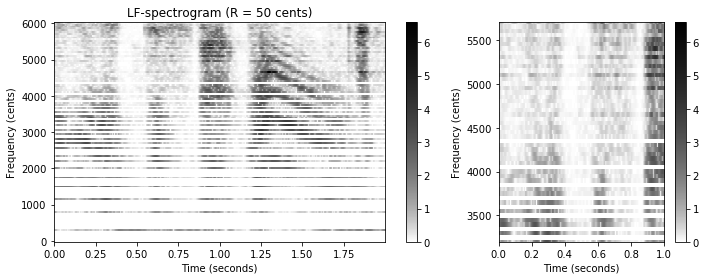

In [3]:
@jit(nopython=True)
def f_coef(k, Fs, N):
    """STFT center frequency

    Notebook: C8/C8S2_SalienceRepresentation.ipynb

    Args:
        k (int): Coefficient number
        Fs  (scalar): Sampling rate in Hz
        N (int): Window length in samples

    Returns:
        freq (float): STFT center frequency
    """
    return k * Fs / N

@jit(nopython=True)
def frequency_to_bin_index(F, R=10.0, F_ref=55.0):
    """| Binning function with variable frequency resolution
    | Note: Indexing starts with 0 (opposed to [FMP, Eq. (8.49)])

    Notebook: C8/C8S2_SalienceRepresentation.ipynb

    Args:
        F (float): Frequency in Hz
        R (float): Frequency resolution in cents (Default value = 10.0)
        F_ref (float): Reference frequency in Hz (Default value = 55.0)

    Returns:
        bin_index (int): Index for bin (starting with index 0)
    """
    bin_index = np.floor((1200 / R) * np.log2(F / F_ref) + 0.5).astype(np.int64)
    return bin_index

@jit(nopython=True)
def p_bin(b, freq, R=10.0, F_ref=55.0):
    """Computes binning mask [FMP, Eq. (8.50)]

    Notebook: C8/C8S2_SalienceRepresentation.ipynb

    Args:
        b (int): Bin index
        freq (float): Center frequency
        R (float): Frequency resolution in cents (Default value = 10.0)
        F_ref (float): Reference frequency in Hz (Default value = 55.0)

    Returns:
        mask (float): Binning mask
    """
    mask = frequency_to_bin_index(freq, R, F_ref) == b
    mask = mask.reshape(-1, 1)
    return mask


@jit(nopython=True)
def compute_y_lf_bin(Y, Fs, N, R=10.0, F_min=55.0, F_max=1760.0):
    """Log-frequency Spectrogram with variable frequency resolution using binning

    Notebook: C8/C8S2_SalienceRepresentation.ipynb

    Args:
        Y (np.ndarray): Magnitude spectrogram
        Fs (scalar): Sampling rate in Hz
        N (int): Window length in samples
        R (float): Frequency resolution in cents (Default value = 10.0)
        F_min (float): Lower frequency bound (reference frequency) (Default value = 55.0)
        F_max (float): Upper frequency bound (is included) (Default value = 1760.0)

    Returns:
        Y_LF_bin (np.ndarray): Binned log-frequency spectrogram
        F_coef_hertz (np.ndarray): Frequency axis in Hz
        F_coef_cents (np.ndarray): Frequency axis in cents
    """
    # [FMP, Eq. (8.51)]
    B = frequency_to_bin_index(np.array([F_max]), R, F_min)[0] + 1
    F_coef_hertz = 2 ** (np.arange(0, B) * R / 1200) * F_min
    F_coef_cents = np.arange(0, B*R, R)
    Y_LF_bin = np.zeros((B, Y.shape[1]))

    K = Y.shape[0]
    freq = f_coef(np.arange(0, K), Fs, N)
    freq_lim_idx = np.where(np.logical_and(freq >= F_min, freq <= F_max))[0]
    freq_lim = freq[freq_lim_idx]
    Y_lim = Y[freq_lim_idx, :]

    for b in range(B):
        coef_mask = p_bin(b, freq_lim, R, F_min)
        Y_LF_bin[b, :] = (Y_lim*coef_mask).sum(axis=0)
    return Y_LF_bin, F_coef_hertz, F_coef_cents

R = 50
F_min = 55.0
F_max = 1760.0

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=figsize)    

Y_LF_bin, F_coef_hertz, F_coef_cents = compute_y_lf_bin(Y, Fs, N, R, F_min=F_min, F_max=F_max)


libfmp.b.plot_matrix(Y_LF_bin, Fs=Fs/H, F_coef=F_coef_cents, ax=[ax[0]], ylabel='Frequency (cents)',
                     title='LF-spectrogram (R = 50 cents)', colorbar=True, cmap=cmap);

libfmp.b.plot_matrix(Y_LF_bin, Fs=Fs/H, F_coef=F_coef_cents, ax=[ax[1]], ylabel='Frequency (cents)',
                     title='', colorbar=True, cmap=cmap);

ylim_zoom_cents = [3200, 5700] 
xlim_zoom = [0,1]
ax[1].set_xlim(xlim_zoom)
ax[1].set_ylim(ylim_zoom_cents)
plt.tight_layout()

## Using Instantaneous Frequency

In the simple binning approach as introduced above, the linearly spaced frequency information in $\mathcal{Y}$ is expanded in a nonlinear, logarithmic fashion. This results in artifacts in the frequency direction (e.g., the horizontal white stripes), which are visible particularly in the lower part of $\mathcal{Y}_\mathrm{LF}$. We now discuss how this problem can be alleviated by using the [instantaneous frequency](../C8/C8S2_InstantFreqEstimation.html) (see also Section 8.2.1 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>). Instead of taking the center frequencies $F_\mathrm{coef}(k)$, the idea is to employ the refined frequency estimates $F_\mathrm{coef}^\mathrm{IF}(k,n)$ 
for defining the sets 

\begin{equation}
    P^\mathrm{IF}(b,n) := \left\{k: \mathrm{Bin}\left(F_\mathrm{coef}^\mathrm{IF}(k, n)\right)=b\right\}
\end{equation}

for $b\in[1:B]$ and $n\in\mathbb{Z}$. From this new bin assignment, we derive a refined log-frequency spectrogram $\mathcal{Y}_\mathrm{LF}^\mathrm{IF}$ by setting

\begin{equation}
\label{eq:AudioDeco:Mel:SalSpec:SpecLogFreqIF}
      \mathcal{Y}_\mathrm{LF}^\mathrm{IF}(n,b) := \sum_{k \in P^\mathrm{IF}(b,n)}{\mathcal{Y}(n,k)}
\end{equation}

for each frame index $n\in\mathbb{Z}$ and bin index $b\in[1:B]$. The effect of this modification is illustrated by the following code cell. Note that using the instantaneous frequency alleviates some of the problems introduced by the [linear frequency grid of the STFT](../C2/C2_STFT-FreqGridDensity.html). In particular time&ndash;frequency patterns become sharper when spectral coefficients can be clearly assigned to a single harmonic source.

<!--<img src="../data/C8/FMP_C8_F14c.png" width="500px" align="middle" alt="FMP_C8_F14c">-->

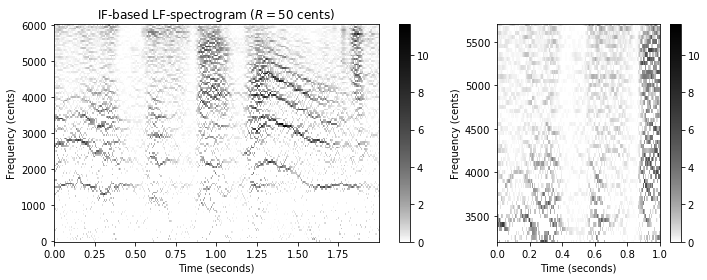

In [4]:
@jit(nopython=True)
def p_bin_if(b, F_coef_IF, R=10.0, F_ref=55.0):
    """Computes binning mask for instantaneous frequency binning [FMP, Eq. (8.52)]

    Notebook: C8/C8S2_SalienceRepresentation.ipynb

    Args:
        b (int): Bin index
        F_coef_IF (float): Instantaneous frequencies
        R (float): Frequency resolution in cents (Default value = 10.0)
        F_ref (float): Reference frequency in Hz (Default value = 55.0)

    Returns:
        mask (np.ndarray): Binning mask
    """
    mask = frequency_to_bin_index(F_coef_IF, R, F_ref) == b
    return mask

@jit(nopython=True)
def compute_y_lf_if_bin(X, Fs, N, H, R=10, F_min=55.0, F_max=1760.0, gamma=0.0):
    """Binned Log-frequency Spectrogram with variable frequency resolution based on instantaneous frequency

    Notebook: C8/C8S2_SalienceRepresentation.ipynb

    Args:
        X (np.ndarray): Complex spectrogram
        Fs (scalar): Sampling rate in Hz
        N (int): Window length in samples
        H (int): Hopsize in samples
        R (float): Frequency resolution in cents (Default value = 10)
        F_min (float): Lower frequency bound (reference frequency) (Default value = 55.0)
        F_max (float): Upper frequency bound (Default value = 1760.0)
        gamma (float): Logarithmic compression factor (Default value = 0.0)

    Returns:
        Y_LF_IF_bin (np.ndarray): Binned log-frequency spectrogram using instantaneous frequency
        F_coef_hertz (np.ndarray): Frequency axis in Hz
        F_coef_cents (np.ndarray): Frequency axis in cents
    """
    # Compute instantaneous frequencies
    F_coef_IF = libfmp.c8.compute_if(X, Fs, N, H)
    freq_lim_mask = np.logical_and(F_coef_IF >= F_min, F_coef_IF < F_max)
    F_coef_IF = F_coef_IF * freq_lim_mask

    # Initialize ouput array and compute frequency axis
    B = frequency_to_bin_index(np.array([F_max]), R, F_min)[0] + 1
    F_coef_hertz = 2 ** (np.arange(0, B) * R / 1200) * F_min
    F_coef_cents = np.arange(0, B*R, R)
    Y_LF_IF_bin = np.zeros((B, X.shape[1]))

    # Magnitude binning
    if gamma == 0:
        Y = np.abs(X) ** 2
    else:
        Y = np.log(1 + np.float32(gamma)*np.abs(X))
    for b in range(B):
        coef_mask = p_bin_if(b, F_coef_IF, R, F_min)

        Y_LF_IF_bin[b, :] = (Y * coef_mask).sum(axis=0)
    return Y_LF_IF_bin, F_coef_hertz, F_coef_cents


R = 50
F_min = 55.0
F_max = 1760.0
Y_LF_IF_bin, F_coef, F_coef_cents = compute_y_lf_if_bin(X, Fs, N, H, R=R, 
                                                        F_min=F_min, F_max=F_max, gamma=1)

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=figsize)  
libfmp.b.plot_matrix(Y_LF_IF_bin, Fs=Fs/H, F_coef=F_coef_cents, ax=[ax[0]], ylabel='Frequency (cents)',
                     title=r'IF-based LF-spectrogram ($R = %0.0f$ cents)'%R, colorbar=True, cmap=cmap);

libfmp.b.plot_matrix(Y_LF_IF_bin, Fs=Fs/H, F_coef=F_coef_cents, ax=[ax[1]], ylabel='Frequency (cents)',
                     title='', colorbar=True, cmap=cmap);
ax[1].set_xlim(xlim_zoom)
ax[1].set_ylim(ylim_zoom_cents)
plt.tight_layout()

In the following figure, we show the IF-based log-frequency spectrogram using a resolution of $R=10$ cents. Note that, even at this high frequency resolution, the artifacts due to empty frequency bins are barely visible.

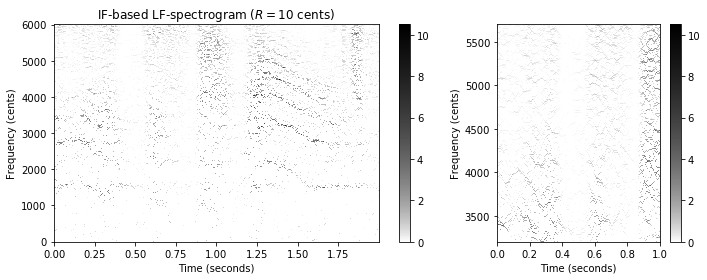

In [5]:
R = 10
Y_LF_IF_bin, F_coef, F_coef_cents = compute_y_lf_if_bin(X, Fs, N, H, R=R, 
                                                        F_min=F_min, F_max=F_max, gamma=1)

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=figsize) 
libfmp.b.plot_matrix(Y_LF_IF_bin, Fs=Fs/H, F_coef=F_coef_cents, ax=[ax[0]], ylabel='Frequency (cents)', 
                     title='IF-based LF-spectrogram ($R = %0.0f$ cents)'%R, colorbar=True, cmap=cmap);

libfmp.b.plot_matrix(Y_LF_IF_bin, Fs=Fs/H, F_coef=F_coef_cents, ax=[ax[1]], ylabel='Frequency (cents)', 
                     title='', colorbar=True, cmap=cmap);
ax[1].set_xlim(xlim_zoom)
ax[1].set_ylim(ylim_zoom_cents)
plt.tight_layout()

## Harmonic Summation

Recall that a sound event such as a musical tone is associated to a fundamental frequency along with its harmonic partials, which are (approximately) the integer multiples of the fundamental frequency. Therefore, a spectrogram representation of a recorded melody typically exhibits an entire family of frequency trajectories which are stacked on top of each other. The multiple appearance of tonal time&ndash;frequency patterns can be exploited to improve a spectrogram representation. The idea is to jointly consider a frequency and its harmonics by forming suitably weighted sums&mdash;a technique also called **harmonic summation**. Let $H\in\mathbb{N}$ be the number of harmonics to be considered in the summation. Then, given a spectrogram representation $\mathcal{Y}$, we define a harmonic-sum spectrogram $\tilde{\mathcal{Y}}$ by setting

\begin{equation}
    \tilde{\mathcal{Y}}(n,k) := \sum_{h=1}^{H} \alpha^{h-1} \cdot  \mathcal{Y}(n,k\cdot h) 
\end{equation}

for $n,k\in\mathbb{Z}$ (assuming that $\mathcal{Y}$ is suitably zero-padded in frequency direction). In the summation, harmonics may be weighted exponentially using the weighting parameter $\alpha \in [0, 1]$.

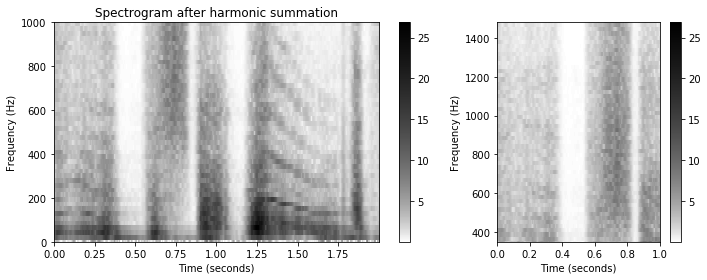

In [6]:
@jit(nopython=True)
def harmonic_summation(Y, num_harm=10, alpha=1.0):
    """Harmonic summation for spectrogram [FMP, Eq. (8.54)]

    Notebook: C8/C8S2_SalienceRepresentation.ipynb

    Args:
        Y (np.ndarray): Magnitude spectrogram
        num_harm (int): Number of harmonics (Default value = 10)
        alpha (float): Weighting parameter (Default value = 1.0)

    Returns:
        Y_HS (np.ndarray): Spectrogram after harmonic summation
    """
    Y_HS = np.zeros(Y.shape)
    Y_zero_pad = np.vstack((Y, np.zeros((Y.shape[0]*num_harm, Y.shape[1]))))
    K = Y.shape[0]
    for k in range(K):
        harm_idx = np.arange(1, num_harm+1)*(k)
        weights = alpha ** (np.arange(1, num_harm+1) - 1).reshape(-1, 1)
        Y_HS[k, :] = (Y_zero_pad[harm_idx, :] * weights).sum(axis=0)
    return Y_HS

Y_HS = harmonic_summation(Y, num_harm=10)

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=figsize)        

libfmp.b.plot_matrix(Y_HS, Fs=Fs/H, Fs_F=N/Fs, ax=[ax[0]], title='Spectrogram after harmonic summation', colorbar=True, cmap=cmap);
ax[0].set_ylim([0, 1000])
libfmp.b.plot_matrix(Y_HS, Fs=Fs/H, Fs_F=N/Fs, ax=[ax[1]], title='', colorbar=True, cmap=cmap);
ax[1].set_ylim(ylim_zoom)
ax[1].set_xlim(xlim_zoom)

plt.tight_layout()

## Salience Representation

A similar construction can be applied for log-frequency spectrogram representations such as $\mathcal{Y}_\mathrm{LF}$ or $\mathcal{Y}_\mathrm{LF}^\mathrm{IF}$.  In this case, however, one requires a modification in the harmonic summation. In particular, working in the log-frequency domain, the relation between a frequency and its harmonics is not a multiplicative but an additive one. For example, in the case of the log-frequency spectrogram $\mathcal{Y}_\mathrm{LF}^\mathrm{IF}$ one obtains its harmonic-sum version $\mathcal{Z}:=\tilde{\mathcal{Y}}_\mathrm{LF}^\mathrm{IF}$ by setting 

\begin{equation}
    \mathcal{Z}(n,b) := \sum_{h=1}^{H} \alpha^{h-1} \cdot  \mathcal{Y}_\mathrm{LF}^\mathrm{IF}\left(n,b+ \left\lfloor \frac{1200}{R}\log_2(h)\right\rfloor\right) 
\end{equation}

Emphasizing the salience of tonal frequency components, $\mathcal{Z}$ is also referred to as a **salience representation**. The following code cells implements the harmonic summation for log-frequency representations. 

<!-- <img src="../data/C8/FMP_C8_F15.png" width="500px" align="middle" alt="FMP_C8_F15">-->

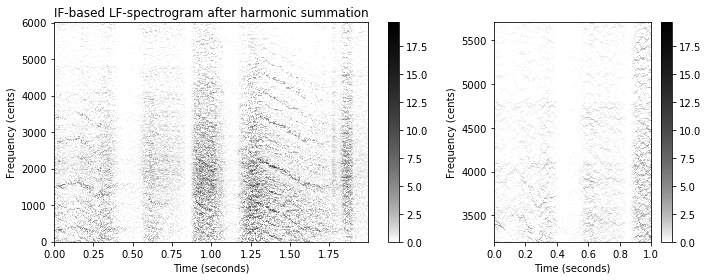

In [7]:
@jit(nopython=True)
def harmonic_summation_lf(Y_LF_bin, R, num_harm=10, alpha=1.0):
    """Harmonic summation for log-frequency spectrogram [FMP, Eq. (8.55)]

    Notebook: C8/C8S2_SalienceRepresentation.ipynb

    Args:
        Y_LF_bin (np.ndarray): Log-frequency spectrogram
        R (float): Frequency resolution in cents
        num_harm (int): Number of harmonics (Default value = 10)
        alpha (float): Weighting parameter (Default value = 1.0)

    Returns:
        Y_LF_bin_HS (np.ndarray): Log-frequency spectrogram after harmonic summation
    """
    Y_LF_bin_HS = np.zeros(Y_LF_bin.shape)
    pad_len = int(np.floor(np.log2(num_harm) * 1200 / R))
    Y_LF_bin_zero_pad = np.vstack((Y_LF_bin, np.zeros((pad_len, Y_LF_bin.shape[1]))))
    B = Y_LF_bin.shape[0]
    for b in range(B):
        harmonics = np.arange(1, num_harm+1)
        harm_idx = b + np.floor(np.log2(harmonics) * 1200 / R).astype(np.int64)
        weights = alpha ** (np.arange(1, num_harm+1) - 1).reshape(-1, 1)
        Y_LF_bin_HS[b, :] = (Y_LF_bin_zero_pad[harm_idx, :] * weights).sum(axis=0)
    return Y_LF_bin_HS

Y_LF_IF_bin_HS = harmonic_summation_lf(Y_LF_IF_bin, num_harm=10, R=R)

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=figsize)   

libfmp.b.plot_matrix(Y_LF_IF_bin_HS, Fs=Fs/H, F_coef=F_coef_cents, ax=[ax[0]], ylabel='Frequency (cents)', 
                     title='IF-based LF-spectrogram after harmonic summation', colorbar=True, cmap=cmap);

libfmp.b.plot_matrix(Y_LF_IF_bin_HS, Fs=Fs/H, F_coef=F_coef_cents, ax=[ax[1]], ylabel='Frequency (cents)', 
                     title='', colorbar=True, cmap=cmap);
ax[1].set_xlim(xlim_zoom)
ax[1].set_ylim(ylim_zoom_cents)
plt.tight_layout()

Looking at the visualization, the effect of harmonic summation does not seem to be huge. There are many parameters that may have a significant influence on the final result. In particular, a high frequency resolution in combination with the IF-based sharpening may lead to problems in the harmonic summation due to **small deviations across harmonically related bins**. A simple method for increasing the robustness of the harmonic summation is to introduce a **smoothing step along the frequency axis**. This step, as indicated by the next figure, may have a significant effect on the resulting salience representation. The next code cell summarizes the overall procedure by providing an implementation for computing the final salience representation.

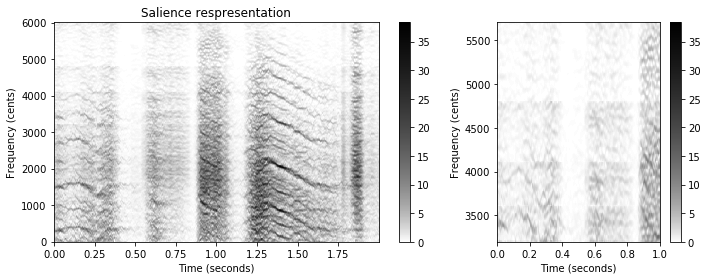

In [8]:
def compute_salience_rep(x, Fs, N, H, R, F_min=55.0, F_max=1760.0, num_harm=10, freq_smooth_len=11, alpha=1.0,
                         gamma=0.0):
    """Salience representation [FMP, Eq. (8.56)]

    Notebook: C8/C8S2_SalienceRepresentation.ipynb

    Args:
        x (np.ndarray): Audio signal
        Fs (scalar): Sampling frequency
        N (int): Window length in samples
        H (int): Hopsize in samples
        R (float): Frequency resolution in cents
        F_min (float): Lower frequency bound (reference frequency) (Default value = 55.0)
        F_max (float): Upper frequency bound (Default value = 1760.0)
        num_harm (int): Number of harmonics (Default value = 10)
        freq_smooth_len (int): Filter length for vertical smoothing (Default value = 11)
        alpha (float): Weighting parameter (Default value = 1.0)
        gamma (float): Logarithmic compression factor (Default value = 0.0)

    Returns:
        Z (np.ndarray): Salience representation
        F_coef_hertz (np.ndarray): Frequency axis in Hz
        F_coef_cents (np.ndarray): Frequency axis in cents
    """
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, pad_mode='constant')
    Y_LF_IF_bin, F_coef_hertz, F_coef_cents = compute_y_lf_if_bin(X, Fs, N, H, R, F_min, F_max, gamma=gamma)
    # smoothing
    Y_LF_IF_bin = ndimage.filters.convolve1d(Y_LF_IF_bin, np.hanning(freq_smooth_len), axis=0, mode='constant')
    Z = harmonic_summation_lf(Y_LF_IF_bin, R=R, num_harm=num_harm, alpha=alpha)
    return Z, F_coef_hertz, F_coef_cents

Z, F_coef_hertz, F_coef_cents = compute_salience_rep(x, Fs, N=1024, H=128, R=10, 
                                                     num_harm=10, freq_smooth_len=11, alpha=1, gamma=1)

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=figsize)   

libfmp.b.plot_matrix(Z, Fs=Fs/H, F_coef=F_coef_cents, ax=[ax[0]], ylabel='Frequency (cents)',
                     title='Salience respresentation', colorbar=True, cmap=cmap);

libfmp.b.plot_matrix(Z, Fs=Fs/H, F_coef=F_coef_cents, ax=[ax[1]], ylabel='Frequency (cents)', 
                     title='', colorbar=True, cmap=cmap);
ax[1].set_xlim(xlim_zoom)
ax[1].set_ylim(ylim_zoom_cents)
plt.tight_layout()

As shown by this figure, the summation process amplifies the dominating tonal components, while noise-like artifacts as introduced by the instantaneous frequency estimation are attenuated. On the downside, the process produces **ghost components** that appear particularly in the lower frequency range of the spectrogram (see, e.g., the vibrato around the frequency $3500$ cents in the right plot). This, however, is not a major problem when one is looking only for the <a href="../C8/C8S2_FundFreqTracking.html">predominant frequency trajectories</a> (Section 8.2.3 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>).

## Summary and Further Notes

In summary, the construction of our salience representation $\mathcal{Z}$ is motivated by several assumptions and observations. 

* First, the logarithmic frequency binning accounts for the logarithmic perception of frequency and the musical notion of a note's pitch. 
* Second, using the instantaneous frequency improves the accuracy of the frequency estimates. 
* Third, the harmonic summation amplifies the regularly spaced frequency components. This accounts for the fact that a tone's energy is not only contained in the fundamental frequency, but spread over the entire harmonic spectrum.

Furthermore, we have seen that the additional smoothing step before the harmonic summation may yield significant improvements in the final salience representation. In general, when applying **local** operations to data that is sampled with high resolution, small deviations or outliers in the data may lead to considerable degradations. In such situations, additional filtering steps (such as convolution with a Gaussian kernel or median filtering) may help to alleviate some of the problems. In our case, smoothing helped to balance out small deviations in frequency bins before applying harmonic summation. In the context of [novelty-based boundary detection](../C4/C4S4_StructureFeature.html), we applied a similar strategy. Here, to compute the novelty function $\Delta_\mathrm{Structure}$, additional filtering was beneficial before computing the local difference between successive features.

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and <a href="https://www.audiolabs-erlangen.de/fau/assistant/rosenzweig">Sebastian Rosenzweig</a>.</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>